# decappingQuantification4_finalVersions.ipynb
## Marcus Viscardi,    August 19, 2024\

I need to finalize some of these plots and get them ready for publication.

Generally, I want to take the pre-processed data from previous notebooks and create the final versions. I'll try to be good about using markdown blocks to label what I am doing in each section!

In [2]:
from typing import Tuple

import nanoporePipelineCommon as npCommon

import numpy as np
import pandas as pd

import re

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm.auto import tqdm

from icecream import ic
from datetime import datetime

from pathlib import Path

from scipy.stats import mannwhitneyu, ks_2samp

import pickle as pkl

import random

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

def __time_formatter__():
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"ic: {now} | > "
ic.configureOutput(prefix=__time_formatter__)

_ = ic("Imports done!")

ic: 2024-09-11 11:38:51 | > 'Imports done!'


### Load some of the pre-processed data

### This pre-processed dataframe comes from `decappingQuantification2_metaPlots.ipynb` and is the data that has been cleaned up and had the near TSS data added to it.

In [3]:
gtf_parquet_path = Path("/data16/marcus/genomes/plus_cerENO2_elegansRelease100/230327_allChrs_plus-cerENO2.gtf.parquet")

gtf_df = pd.read_parquet(gtf_parquet_path)

current_dir = Path.cwd()

In [4]:
preprocessed_df = pd.read_parquet(current_dir / "preprocessed_data" / "decapping_data.parquet")
preprocessed_df.head(10)

,gene_name,nmd_target_type,lib,adapted_near_stop,adapted_near_tss,total_adapted,unadapted_near_stop,unadapted_near_tss,total_unadapted,strain,total_near_tss,total_near_stop,total_reads,frac_near_tss
0,rsp-6,NMD_Targets,oldN2,2,0,4,2,9,17,wildtype,9,4,21,0.0
1,rsp-6,NMD_Targets,newerN2,0,0,9,4,4,19,wildtype,4,4,28,0.0
2,rsp-6,NMD_Targets,newerS6,0,0,0,53,115,235,smg-6,115,53,235,0.0
3,rsp-6,NMD_Targets,newerS5,1,0,1,20,61,110,smg-5,61,21,111,0.0
4,rsp-6,NMD_Targets,thirdN2,2,0,4,4,3,18,wildtype,3,6,22,0.0
5,rsp-6,NMD_Targets,thirdS5,0,0,1,29,86,184,smg-5,86,29,185,0.0
6,rsp-6,NMD_Targets,thirdS6,0,0,0,12,10,33,smg-6,10,12,33,0.0
7,rsp-6,NMD_Targets,temp25cN2,0,0,2,3,3,12,wildtype,3,3,14,0.0
8,rsp-6,NMD_Targets,temp25cS5,0,0,0,14,78,114,smg-5,78,14,114,0.0
9,rsp-6,NMD_Targets,temp25cS6,0,0,0,23,54,111,smg-6,54,23,111,0.0


### Trying to make a better script/box plot:

I want to connect genes with the same name across species and NMD_types. Going to lean on the following post: [Stack Overflow](https://stackoverflow.com/q/60164606/13316742)

In [5]:
df = preprocessed_df.copy()
df.set_index(['gene_name', 'nmd_target_type', 'lib', 'strain'], inplace=True)
# print(df.index.get_level_values('nmd_target_type').unique())
in_df = df[['adapted_near_tss', 'total_adapted', 'total_reads', 'unadapted_near_tss', 'total_near_tss']].fillna(0).reset_index()

set_dict = {'old': 1, 'newer': 2, 'third': 3, 'temp25c': 4}

in_df['rep'] = in_df.lib.str[:-2].map(set_dict)
in_df = in_df.query("strain != 'smg-7'")
in_df = in_df.set_index(['gene_name', 'strain', 'rep','lib', 'nmd_target_type']).sort_index()
better_df = in_df.loc[:, :, :, :, ['NMD_Targets', 'NMD_NonTargets', 'Ambiguous_Reads'], :]
better_df.head()

adapted_near_tss  total_adapted  total_reads  unadapted_near_tss  total_near_tss
gene_name strain rep lib       nmd_target_type                                                                                  
C53H9.2   smg-5  2   newerS5   NMD_Targets                     0              1          140                  92              92
                 3   thirdS5   NMD_Targets                     0              2          213                 124             124
                 4   temp25cS5 NMD_Targets                     0              0          115                  87              87
          smg-6  2   newerS6   NMD_Targets                     2              3          202                 126             128
                 3   thirdS6   NMD_Targets                     0              1           35                  15              15

This is a working version of the boxplots from `decappingQuantification2_metaPlots.ipynb` I can use it as a starting point if I get confused...

In [6]:
def process_df_for_means(input_df: pd.DataFrame,
                         target_num: str, target_denom: str,
                         min_total_reads: int = 1,
                         min_adapted_reads: int = 1,
                         min_tss_ada_reads: int = 0,
                         add_tss_ada_pseudo: float = -1.0,
                         min_number_reps_observed: int = -1,
                         log2_y: bool = False,
                         log_y: bool = True,
                         print_failed_genes: bool = False,
                         ) -> pd.DataFrame:
    input_df = input_df.copy()
    
    target_col = f"{target_num} / {target_denom}"
    
    input_df['adapted_near_tss'] = input_df['adapted_near_tss'].fillna(0)
    if add_tss_ada_pseudo > 0:
        input_df['adapted_near_tss'] += add_tss_ada_pseudo
    input_df['unadapted_near_tss'] = input_df['unadapted_near_tss'].fillna(0)
    input_df['total_near_tss'] = input_df['adapted_near_tss'] + input_df['unadapted_near_tss']
    input_df[target_col] = input_df[target_num] / input_df[target_denom]
    
    box_df = input_df.copy().reset_index()
    
    box_df['strain'] = pd.Categorical(box_df['strain'], ['wildtype', 'smg-5', 'smg-6', 'smg-7'])
    box_df.sort_values(by=['strain', 'nmd_target_type'], inplace=True)
    
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'].astype(str)
    
    box_df = box_df[box_df['total_reads'] >= min_total_reads].dropna(axis=0)
    box_df = box_df[box_df['total_adapted'] >= min_adapted_reads].dropna(axis=0)
    
    if log2_y:
        box_df = box_df[box_df[target_col] > 0]
        box_df[f"log2({target_col})"] = np.log2(box_df[target_col])
        target_col = f"log2({target_col})"
        log_y = False
    
    if log_y:
        box_df = box_df[box_df[target_col] > 0]
    
    if min_tss_ada_reads > 0:
        box_df = box_df[box_df['adapted_near_tss'] >= min_tss_ada_reads]
    
    index_fixed_box_df = box_df.reset_index().set_index(['strain', 'gene_name', 'nmd_target_type'])
    groupby_obj = index_fixed_box_df.groupby(['strain', 'gene_name', 'nmd_target_type'], observed=True)
    og_numerical_cols = index_fixed_box_df.select_dtypes(include=[np.number]).columns.to_list()
    keep_cols = [target_col, target_num, target_denom, 'total_near_tss', 'total_reads', 'adapted_near_tss', 'unadapted_near_tss'] + og_numerical_cols
    keep_cols = list(set(keep_cols))
    groupby_df = groupby_obj[keep_cols].mean()
    std_cols = [f'{col}_std' for col in keep_cols]
    groupby_df[std_cols] = groupby_obj[keep_cols].std()
    groupby_df['successful_reps'] = groupby_obj['rep'].apply(lambda x: ','.join(map(str, x)))
    groupby_df['num_successful_reps'] = groupby_obj['rep'].count()
    groupby_df.reset_index(inplace=True)
    if min_number_reps_observed > 0:
        if print_failed_genes:
            print(f"Failed Genes at `min_number_reps_observed >= {min_number_reps_observed}` level:")
            print(groupby_df.query("num_successful_reps < @min_number_reps_observed")[['gene_name', 'strain', 'gene_name', 'nmd_target_type', 'num_successful_reps']])
        groupby_df = groupby_df.query("num_successful_reps >= @min_number_reps_observed")
    return groupby_df

Now let's try to manually make a similar version to above, from there we can start building up the attached version!!

In [7]:
# random.seed(42)
# 
# plot_num = 'adapted_near_tss'
# plot_denum = 'total_adapted'
# plot_col = f'{plot_num} / {plot_denum}'
# 
# min_adapted = 3
# min_total = 10
# 
# plot_df = better_df.copy().query(f"total_adapted >= {min_adapted} & total_reads >= {min_total}")
# plot_df[plot_col] = plot_df[plot_num] / df[plot_denum]
# base_value_dict = {'wildtype': 1,
#                    'smg-5': 2,
#                    'smg-6': 3,
#                    # 'smg-7': 4,
#                    }
# adjusted_value_dict = {'NMD_Targets': -0.15,
#                        'NMD_NonTargets': 0.15}
# # These colors are updated from the final plots!
# plot_colors = (('#37c871', '#16502d'),  # NMD greens
#                ('#64a7ff', '#00008b'),  # Non NMD blues
#                ('#676767', '#414141'),  # ambiguous greys
#                )
# colors_dict = {'NMD_Targets': plot_colors[0][0],
#                'NMD_NonTargets': plot_colors[1][0],}
# 
# def adjust_value(row: pd.Series) -> float:
#     strain = row.name[1]
#     nmd_target_type = row.name[4]
#     return base_value_dict[strain] + adjusted_value_dict[nmd_target_type] + (random.random() - 0.5) * 0.1
# 
# plot_df['adjusted_x'] = plot_df.apply(adjust_value, axis=1)
# 
# fig, ax = plt.subplots(figsize=(8, 8))
# for strain in plot_df.index.get_level_values('strain').unique():
#     added_points_rows = []
#     for gene in plot_df.index.get_level_values('gene_name').unique():
#         for rep in plot_df.index.get_level_values('rep').unique():
#             rows = plot_df.query(f"gene_name == '{gene}' & strain == '{strain}' & rep == {rep}")
#             nmd_vals = rows.index.get_level_values('nmd_target_type').unique().to_list()
#             if len(nmd_vals) == 2:
#                 for nmd_val in nmd_vals:
#                     ax.plot(rows.query(f"nmd_target_type == '{nmd_val}'")['adjusted_x'],
#                             rows.query(f"nmd_target_type == '{nmd_val}'")[plot_col],
#                             marker='o', linestyle='', markersize=5, color=colors_dict[nmd_val])
#                 ax.plot(rows['adjusted_x'], rows[plot_col], color='black', alpha=0.5, linewidth=0.5, dashes=[6, 2])
#                 added_points_rows.append(rows)
#     added_points_df = pd.concat(added_points_rows)
#     for nmd_val, color in colors_dict.items():
#         subplot_df = added_points_df.query(f"nmd_target_type == '{nmd_val}'")
#         ax.boxplot(subplot_df[plot_col],
#                    vert=True,
#                    positions=[2.5*adjusted_value_dict[nmd_val]+base_value_dict[strain]],
#                    widths=(adjusted_value_dict[nmd_val]*1.5),
#                    meanline=True,
#                    patch_artist=True,
#                    showmeans=True,
#                    showfliers=False,
#                    boxprops=dict(facecolor=color),
#                    )
# ax.set_xticks(list(base_value_dict.values()))
# ax.set_xticklabels(list(base_value_dict.keys()))
# ax.set_ylabel(f"{plot_num} / {plot_denum}")
# lines = [plt.Line2D([0], [0], color=colors_dict[nmd_val], lw=2, label=nmd_val) for nmd_val in colors_dict.keys()]
# ax.legend(lines, colors_dict.keys())
# plt.show()
# added_points_df

### Now let's make that same plot but while using averages for each gene and connections between observations of the same gene

In [20]:
from matplotlib import colormaps as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# def plot_box_and_strip_with_connections(in_df: pd.DataFrame,
#                                         plot_num: str,  # 'adapted_near_tss'
#                                         plot_denum: str,  # 'total_adapted' or 'total_reads'
#                                         min_adapted: int = 3,
#                                         min_total: int = 10,
#                                         min_tss_ada: int = 0,
#                                         add_tss_ada_pseudo: float = 0.0,
#                                         min_number_reps_observed: int = -1,
#                                         with_connections: bool = True,
#                                         log2_y: bool = False,
#                                         log_y: bool = False,
#                                         with_gene_names=True,
#                                         save_dir: Path = current_dir / 'plots' / 'decapping_connectedMeans',
#                                         additional_save_text:str = '',
#                                         ) -> Tuple[pd.DataFrame, pd.DataFrame, go.Figure]:
#     random.seed(42)
#     fig, ax = plt.subplots(figsize=(6, 4),)
#     spacing_factor = 0.20  # 0.15
#     box_pos_scaler = 3.25   # 3.5
#     box_width_scaler = 3.0 # 2.5
#     
#     
#     plot_col = f'{plot_num} / {plot_denum}'
#     plot_df = in_df.copy()
#     
#     plot_df = plot_df.query(f"total_adapted >= {min_adapted} & total_reads >= {min_total}")
#     plot_df[plot_col] = plot_df[plot_num] / plot_df[plot_denum]
#     
#     plot_df = process_df_for_means(plot_df,
#                                    plot_num, plot_denum,
#                                    min_total_reads=min_total,
#                                    min_adapted_reads=min_adapted,
#                                    min_tss_ada_reads=min_tss_ada,
#                                    add_tss_ada_pseudo=add_tss_ada_pseudo,
#                                    min_number_reps_observed=min_number_reps_observed,
#                                    log2_y=log2_y,
#                                    log_y=log_y,
#                                    )
#     
#     base_value_dict = {'wildtype': 0,
#                        'smg-5': 2,
#                        'smg-6': 4,
#                        # 'smg-7': 4,
#                        }
#     adjusted_value_dict = {'NMD_Targets': spacing_factor,
#                            'NMD_NonTargets': -spacing_factor}
#     # These colors are updated from the final plots!
#     plot_colors = (('#37c871', '#16502d'),  # NMD greens
#                    ('#64a7ff', '#00008b'),  # Non NMD blues
#                    ('#676767', '#414141'),  # ambiguous greys
#                    )
#     colors_dict = {'NMD_Targets': plot_colors[0][0],
#                    'NMD_NonTargets': plot_colors[1][0],}
#     
#     def adjust_value2(row: pd.Series) -> float:
#         strain = row.strain
#         nmd_target_type = row.nmd_target_type
#         return base_value_dict[strain] + adjusted_value_dict[nmd_target_type] + (random.random() - 0.5) * 0.1
#     
#     plot_df['adjusted_x'] = plot_df.apply(adjust_value2, axis=1)
#     
#     all_points_rows = []
#     gene_counter_dict = {strain: dict(NMD_Targets=0, NMD_NonTargets=0) for strain in base_value_dict.keys()}
#     for strain in plot_df.strain.unique():
#         added_points_rows = []
#         for gene in plot_df.gene_name.unique():
#             rows = plot_df.query(f"gene_name == '{gene}' & strain == '{strain}'")
#             nmd_vals = rows.nmd_target_type.unique()
#             if len(nmd_vals) == 2 and with_connections:
#                 ax.plot(rows['adjusted_x'], rows[plot_col], color='black', alpha=0.5, linewidth=0.5, dashes=[6, 2])
#             for nmd_val in nmd_vals:
#                 ax.plot(rows.query(f"nmd_target_type == '{nmd_val}'")['adjusted_x'],
#                         rows.query(f"nmd_target_type == '{nmd_val}'")[plot_col],
#                         marker='o', linestyle='', markersize=5, color=colors_dict[nmd_val],
#                         markeredgecolor='black', markeredgewidth=0.5,)
#                 if with_gene_names:
#                     ax.text(rows.query(f"nmd_target_type == '{nmd_val}'")['adjusted_x'].mean(),
#                             rows.query(f"nmd_target_type == '{nmd_val}'")[plot_col].mean(),
#                             gene, fontsize=8, color='black', alpha=0.5)
#                 gene_counter_dict[strain][nmd_val] += 1
#             added_points_rows.append(rows)
#             all_points_rows.append(rows)
#         added_points_df = pd.concat(added_points_rows)
#         for nmd_val, color in colors_dict.items():
#             subplot_df = added_points_df.query(f"nmd_target_type == '{nmd_val}'")
#             ax.boxplot(subplot_df[plot_col],
#                        vert=True,
#                        positions=[box_pos_scaler*adjusted_value_dict[nmd_val]+base_value_dict[strain]],
#                        widths=(adjusted_value_dict[nmd_val]*box_width_scaler),
#                        meanline=True,
#                        patch_artist=True,
#                        showmeans=True,
#                        showfliers=False,
#                        boxprops=dict(facecolor=color),
#                        )
#     better_tick_labels = {}
#     for old_label, pos in base_value_dict.items():
#         better_tick_labels[(f"{old_label}\n"
#                             f"n = ({gene_counter_dict[old_label]['NMD_NonTargets']}, {gene_counter_dict[old_label]['NMD_Targets']})")] = pos
#     ax.set_xticks(list(better_tick_labels.values()))
#     ax.set_xticklabels(list(better_tick_labels.keys()))
#     ax.set_ylabel(f"{plot_num} / {plot_denum}")
#     lines = [plt.Line2D([0], [0], color=colors_dict[nmd_val], lw=2, label=nmd_val) for nmd_val in colors_dict.keys()]
#     ax.legend(lines, colors_dict.keys())
#     if log_y:
#         plt.yscale('log')
#     plt.tight_layout()
#     save_name = f"{npCommon.get_dt(for_file=True)}_boxPlot_{plot_num}vs{plot_denum}"
#     if log_y:
#         save_name += '_logY'
#     else:
#         save_name += '_linY'
#     save_name += f"_minAdapted{min_adapted}_minTotal{min_total}_minTSSAda{min_tss_ada}_minReps{min_number_reps_observed}_pseudoTSS{add_tss_ada_pseudo}"
#     if with_connections:
#         save_name += '_withConnections'
#     else:
#         save_name += '_noConnections'
#     
#     if additional_save_text:
#         save_name += f"_{additional_save_text}"
#     save_dir.mkdir(exist_ok=True, parents=False)
#     plt.savefig(save_dir / (save_name+".png"), dpi=300)
#     plt.savefig(save_dir / (save_name+".svg"))
#     plt.grid(True, which="both")
#     plt.show()
#     return (pd.concat(all_points_rows), plot_df,  fig)

def merge_ambig_and_targets(input_df: pd.DataFrame, share_with_both=False, NMD_in_wildtype_only: bool = True) -> pd.DataFrame:
    # Easy way to go about this is to break up all the different NMD_target_types into their own dataframes, then recombine them as needed w/ some renaming
    target_df = input_df.query("nmd_target_type == 'NMD_Targets'").copy()
    non_target_df = input_df.query("nmd_target_type == 'NMD_NonTargets'").copy()
    
    if NMD_in_wildtype_only:
        ambig_df = input_df.query("nmd_target_type == 'Ambiguous_Reads' and strain == 'wildtype'").copy()
    else:
        ambig_df = input_df.query("nmd_target_type == 'Ambiguous_Reads'").copy()
    
    target_df = target_df.add(ambig_df.rename(index={"Ambiguous_Reads": "NMD_Targets"}),
                              fill_value=0)
    if share_with_both:
        non_target_df = non_target_df.add(ambig_df.rename(index={"Ambiguous_Reads": "NMD_NonTargets"}),
                                          fill_value=0)
    output_df = pd.concat([target_df, non_target_df])
    return output_df

def process_transcript_lengths(meaned: pd.DataFrame):
    NMD_ISO_REGIONS = {
        'rpl-30': {'start': 10_436_292,
                   'end': 10_436_409,
                   'region_is_target': True},
        'rps-22': {'start': 1_950_820,  # Now rps-15A
                   'end': 1_950_996,
                   'region_is_target': True},
        'ubl-1': {'start': 3_068_573,  # Now rps-27A
                  'end': 3_068_581,
                  'region_is_target': False},  # The target is actually shorter than the non-target
        'rpl-7A': {'start': 4_389_805,
                   'end': 4_389_886,
                   'region_is_target': True},
        'rpl-3': {'start': 3_868_329,
                  'end': 3_868_443,
                  'region_is_target': True},
        'rpl-1': {'start': 2_876_019,
                  'end': 2_876_144,
                  'region_is_target': True},
        'rpl-12': {'start': 13_240_024,
                   'end': 13_240_143,
                   'region_is_target': True},
        'hel-1': {'start': 8_327_767,
                  'end': 8_327_885,
                  'region_is_target': True},
        'aly-3': {'start': 12_123_830,
                  'end': 12_124_176,
                  'region_is_target': True},
        'rsp-6': {'start': 7_790_498,
                  'end': 7_790_745,
                  'region_is_target': True},
        'K08D12.3': {'start': 1_710_371,
                     'end': 1_710_405,
                     'region_is_target': True},
        'R06C1.4': {'start': 11_931_061,
                    'end': 11_931_173,
                    'region_is_target': True},
        'C53H9.2': {'start': 1_833_384,
                    'end': 1_833_408,
                    'region_is_target': False},  # The target is actually shorter than the non-target
        'rsp-5': {'start': 6_490_718,
                  'end': 6_490_883,
                  'region_is_target': True},
        # These following examples are a little shakier:
        'ZK228.4': {'start': 18_462_943,
                    'end': 18_462_971,
                    'region_is_target': True},  # Not sure about this one's NMD targeted region
        'rpl-26': {'start': 8_603_277,
                   'end': 8_603_324,
                   'region_is_target': True},  # rpl-26 is weird because it doesn't seem to have cleavage buildup/change
        'pqn-70': {'start': 11_227_418,
                   'end': 11_227_453,
                   'region_is_target': False},  # Somewhat unclear, but adding for posterity
                                                # The target is actually shorter than the non-target
        # 'examp': {'start': 3_068_573,
        #           'end': 3_068_581,
        #           'region_is_target': True},
    }
    
    region_lengths = []
    region_lengths_dict = {}
    for gene, region_dict in NMD_ISO_REGIONS.items():
        nmd_longer = 'longer target' if region_dict['region_is_target'] else 'longer non-target'
        region_length = abs(region_dict['end'] - region_dict['start'])
        region_length_adj = region_length if region_dict['region_is_target'] else -region_length
        region_lengths.append(region_length_adj)
        region_lengths_dict[gene] = region_length_adj
    #     print(f"{gene} NMD ID region: {region_length_adj}nt ({nmd_longer})")
    # print(f"\nRegion Lengths Mean: {np.mean(region_lengths):0.2f}; Median {np.median(region_lengths):0.2f}; Std: {np.std(region_lengths):0.2f}")
    
    genes_df = pd.read_parquet(current_dir / 'preprocessed_data' / 'all_genes_avgTranscriptLength_and_nearTSS.parquet')
    just_transcript_lengths = genes_df[['avg_transcript_length', 'std_transcript_length']].reset_index(
        level=['strain', 'rep', 'lib', 'nmd_target_type'],
        drop=True).reset_index().drop_duplicates()
    
    meaned = meaned.merge(just_transcript_lengths, on='gene_name', how='left')
    
    def adjust_length(row: pd.Series) -> float:
        gene = row.gene_name
        length_adjustment = region_lengths_dict.get(gene, 0) / 2
        nmd_target_type = row.nmd_target_type
        if nmd_target_type == 'NMD_Targets':
            return row.avg_transcript_length + length_adjustment
        else:
            return row.avg_transcript_length - length_adjustment
    
    meaned['adj_transcript_length'] = meaned.apply(adjust_length, axis=1)
    return meaned

def plot_box_and_strip_with_connections2(in_df: pd.DataFrame,
                                         plot_num: str,  # 'adapted_near_tss'
                                         plot_denum: str,  # 'total_adapted' or 'total_reads'
                                         min_adapted: int = 3,
                                         min_total: int = 10,
                                         add_tss_ada_pseudo: float = 0.0,
                                         min_number_reps_observed: int = -1,
                                         with_connections: str = '',  # 'length' or 'dashed' or ''/'none'
                                         with_color_bar: bool = True,
                                         log2_y: bool = False,
                                         log_y: bool = False,
                                         with_gene_names: bool = True,
                                         limited_gene_names: list = [],  # if any genes are listed here, only those genes will be labeled
                                         save_dir: Path = current_dir / 'plots' / 'decapping_connectedMeans',
                                         additional_save_text:str = '',
                                         print_failed_genes: bool = False,
                                         remove_manual_outliers: bool = True,
                                         print_mean_median_vals: bool = True,
                                         figsize: Tuple[int, int] = (4, 4),
                                         ) -> Tuple[pd.DataFrame, pd.DataFrame, go.Figure]:
    random.seed(42)
    fig, ax = plt.subplots(figsize=figsize,)
    spacing_factor = 0.20  # 0.15
    box_pos_scaler = 3.25   # 3.5
    box_width_scaler = 3.0 # 2.5
    
    
    plot_col = f'{plot_num} / {plot_denum}'
    plot_df = in_df.copy()
    
    if print_failed_genes:
        print(f"Failed Genes at `total_adapted >= {min_adapted}` or `total_reads >= {min_total}` levels:")
        print(plot_df.query(f"total_adapted < {min_adapted} | total_reads < {min_total}"))
    plot_df = plot_df.query(f"total_adapted >= {min_adapted} & total_reads >= {min_total}")
    if with_connections == 'length':
        plot_df = process_transcript_lengths(plot_df.reset_index())
    else:
        plot_df = plot_df.reset_index()
    plot_df[plot_col] = plot_df[plot_num] / plot_df[plot_denum]
    
    plot_df = process_df_for_means(plot_df,
                                   plot_num, plot_denum,
                                   min_total_reads=min_total,
                                   min_adapted_reads=min_adapted,
                                   min_tss_ada_reads=-1,
                                   add_tss_ada_pseudo=add_tss_ada_pseudo,
                                   min_number_reps_observed=min_number_reps_observed,
                                   log2_y=log2_y,
                                   log_y=log_y,
                                   print_failed_genes=print_failed_genes,
                                   )
    base_value_dict = {'wildtype': 0,
                       'smg-5': 2,
                       'smg-6': 4,
                       # 'smg-7': 4,
                       }
    adjusted_value_dict = {'NMD_Targets': spacing_factor,
                           'NMD_NonTargets': -spacing_factor}
    # These colors are updated from the final plots!
    plot_colors = (('#37c871', '#16502d'),  # NMD greens
                   ('#64a7ff', '#00008b'),  # Non NMD blues
                   ('#676767', '#414141'),  # ambiguous greys
                   )
    if 'adapted' in plot_col:
        colors_dict = {'NMD_Targets': plot_colors[0][0],
                       'NMD_NonTargets': plot_colors[1][0],}
    else:
        colors_dict = {'NMD_Targets': plot_colors[0][1],
                       'NMD_NonTargets': plot_colors[1][1],}
    
    def adjust_value2(row: pd.Series) -> float:
        strain = row.strain
        nmd_target_type = row.nmd_target_type
        return base_value_dict[strain] + adjusted_value_dict[nmd_target_type] + (random.random() - 0.5) * 0.1
    
    # Define the color map and normalization
    cmap = cm.get_cmap('RdYlBu')
    norm = Normalize(vmin=-50, vmax=150)
    
    # Function to convert a value to a color
    def value_to_color(value: float) -> tuple:
        normalized_value = norm(value)
        return cmap(normalized_value)
    
    plot_df['adjusted_x'] = plot_df.apply(adjust_value2, axis=1)
    
    all_points_rows = []
    gene_counter_dict = {strain: dict(NMD_Targets=0, NMD_NonTargets=0) for strain in base_value_dict.keys()}
    for strain in plot_df.strain.unique():
        added_points_rows = []
        for gene in plot_df.gene_name.unique():
            rows = plot_df.query(f"gene_name == '{gene}' & strain == '{strain}'")
            nmd_vals = rows.nmd_target_type.unique()
            
            # Let's get rid of our extreme outliers:
            if remove_manual_outliers:
                if gene == 'hel-1' and strain in ['smg-5', 'smg-6']:
                    continue
                if gene == 'rpl-3' and strain == 'smg-5':
                    continue
                # elif gene == 'pqn-70' and strain == 'smg-6':
                #     continue
                if gene == 'aly-3' and strain == 'smg-6':
                    continue
                if gene == 'C53H9.2' and strain == 'smg-5':
                    continue
                if gene == 'rpl-1' and strain == 'smg-6':
                    continue
                if gene == 'rsp-6' and strain == 'smg-5':
                    continue
            
            if len(nmd_vals) == 2 and with_connections.lower() == 'length':
                # Okay, here is where we want to calculate the difference in NMD targets vs non target legnths and color the dashe3d line by that!!
                # We will also want to add a colorbar to the plot eventually
                difference_in_adj_transcript_len = rows.query("nmd_target_type == 'NMD_Targets'")['adj_transcript_length'].mean() - rows.query("nmd_target_type == 'NMD_NonTargets'")['adj_transcript_length'].mean()
                color = value_to_color(difference_in_adj_transcript_len)
                ax.plot(rows['adjusted_x'], rows[plot_col],
                        color=color, # color='black',
                        # alpha=0.5,
                        linewidth=0.95,
                        # dashes=[6, 2],
                        )
            elif len(nmd_vals) == 2 and with_connections.lower() != 'none' and with_connections:
                # Okay, here is where we want to calculate the difference in NMD targets vs non target legnths and color the dashe3d line by that!!
                # We will also want to add a colorbar to the plot eventually
                ax.plot(rows['adjusted_x'], rows[plot_col],
                        color='black',
                        alpha=0.5,
                        linewidth=0.5,
                        dashes=[6, 2],
                        )
            for nmd_val in nmd_vals:
                ax.plot(rows.query(f"nmd_target_type == '{nmd_val}'")['adjusted_x'],
                        rows.query(f"nmd_target_type == '{nmd_val}'")[plot_col],
                        marker='o', linestyle='', markersize=5, color=colors_dict[nmd_val],
                        markeredgecolor='black', markeredgewidth=0.5,)
                if with_gene_names:
                    if not limited_gene_names or gene in limited_gene_names:
                        ax.text(rows.query(f"nmd_target_type == '{nmd_val}'")['adjusted_x'].mean(),
                                rows.query(f"nmd_target_type == '{nmd_val}'")[plot_col].mean(),
                                gene, fontsize=8, color='black', alpha=0.5)
                gene_counter_dict[strain][nmd_val] += 1
            added_points_rows.append(rows)
            all_points_rows.append(rows)
        added_points_df = pd.concat(added_points_rows)
        for nmd_val, color in colors_dict.items():
            subplot_df = added_points_df.query(f"nmd_target_type == '{nmd_val}'")
            ax.boxplot(subplot_df[plot_col],
                       vert=True,
                       positions=[box_pos_scaler*adjusted_value_dict[nmd_val]+base_value_dict[strain]],
                       widths=(adjusted_value_dict[nmd_val]*box_width_scaler),
                       # meanline=True,
                       patch_artist=True,
                       # showmeans=True,
                       showfliers=False,
                       boxprops=dict(facecolor=color),
                       )
            if print_mean_median_vals:
                print(f"{strain} {nmd_val} mean: {subplot_df[plot_col].mean()*100:0.6f}; median: {subplot_df[plot_col].median()*100:0.6f}")
    better_tick_labels = {}
    for old_label, pos in base_value_dict.items():
        better_tick_labels[(f"{old_label}\n"
                            f"n = ({gene_counter_dict[old_label]['NMD_NonTargets']}, {gene_counter_dict[old_label]['NMD_Targets']})")] = pos
    ax.set_xticks(list(better_tick_labels.values()))
    ax.set_xticklabels(list(better_tick_labels.keys()))
    
    # ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1, 10])
    # ax.set_yticklabels(['0.0001', '0.001', '0.01', '0.1', '1', '10'])
    
    ax.set_ylabel(f"{plot_num} / {plot_denum}")
    
    lines = [plt.Line2D([0], [0], color=colors_dict[nmd_val], lw=2, label=nmd_val) for nmd_val in colors_dict.keys()]
    ax.legend(lines, colors_dict.keys())
    if log_y:
        plt.yscale('log')
    if with_connections.lower() == 'length' and with_color_bar:
        cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
        cbar.set_label('Difference in Adjusted Transcript Length')
    
    save_name = f"{npCommon.get_dt(for_file=True)}_boxPlot_{plot_num}vs{plot_denum}"
    title_text = f"{plot_num} vs {plot_denum}\n"
    if log_y:
        save_name += '_logY'
    else:
        save_name += '_linY'
    save_name += f"_minAdapted{min_adapted}_minTotal{min_total}_minReps{min_number_reps_observed}_pseudoTSS{add_tss_ada_pseudo}"
    title_text += f"Min Adapt: {min_adapted}; Min Total: {min_total}; Min Reps: {min_number_reps_observed}; Pseudo TSS: {add_tss_ada_pseudo}"
    if with_connections.lower() == 'length':
        save_name += '_withLengthConnections'
    elif with_connections.lower() != 'none' and with_connections:
        save_name += '_withConnections'
    else:
        save_name += '_noConnections'
    
    if additional_save_text:
        save_name += f"_{additional_save_text}"
        title_text += f"\n{additional_save_text.replace('_', ' ')}"
    save_dir.mkdir(exist_ok=True, parents=False)
    
    plt.title(title_text)
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.savefig(save_dir / (save_name+".png"), dpi=300)
    plt.savefig(save_dir / (save_name+".svg"))
    plt.show()
    return pd.concat(all_points_rows), plot_df,  fig

wildtype NMD_Targets mean: 1.464332; median: 0.176894
wildtype NMD_NonTargets mean: 63.450113; median: 67.331250
smg-5 NMD_Targets mean: 60.824739; median: 59.760417
smg-5 NMD_NonTargets mean: 73.959659; median: 77.766667
smg-6 NMD_Targets mean: 62.358164; median: 50.719444
smg-6 NMD_NonTargets mean: 78.103327; median: 83.104557


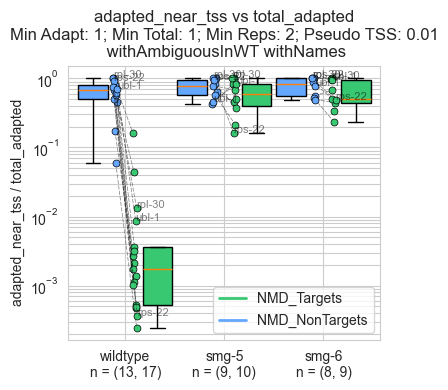

wildtype NMD_Targets mean: 9.225539; median: 7.018516
wildtype NMD_NonTargets mean: 80.115844; median: 79.759646
smg-5 NMD_Targets mean: 76.750346; median: 81.404390
smg-5 NMD_NonTargets mean: 82.755783; median: 82.192635
smg-6 NMD_Targets mean: 69.370122; median: 62.009282
smg-6 NMD_NonTargets mean: 76.565848; median: 73.154514


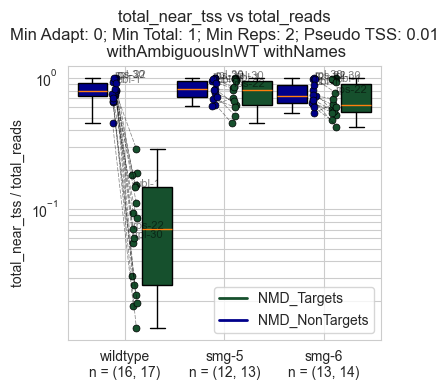

wildtype NMD_Targets mean: 0.158523; median: 0.023584
wildtype NMD_NonTargets mean: 0.595514; median: 0.421307
smg-5 NMD_Targets mean: 0.577339; median: 0.443637
smg-5 NMD_NonTargets mean: 0.568504; median: 0.365166
smg-6 NMD_Targets mean: 0.478968; median: 0.511810
smg-6 NMD_NonTargets mean: 0.496675; median: 0.402730


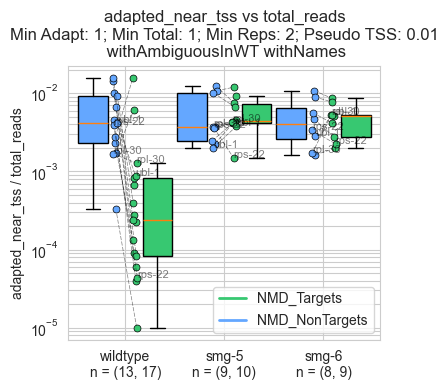

wildtype NMD_Targets mean: 15.211007; median: 12.565336
wildtype NMD_NonTargets mean: 1.049957; median: 0.919286
smg-5 NMD_Targets mean: 1.111357; median: 0.851559
smg-5 NMD_NonTargets mean: 0.739819; median: 0.410278
smg-6 NMD_Targets mean: 0.942951; median: 0.791426
smg-6 NMD_NonTargets mean: 0.704095; median: 0.545140


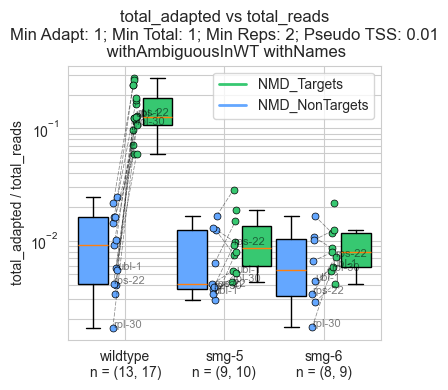

In [21]:
overall_save_dir = Path(f"/home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/decappingFigure/plotsFromPython/{npCommon.get_dt(for_file=True)}_decappingBoxPlots")
overall_save_dir.mkdir(exist_ok=True, parents=False)

# Okay let's run it:
for merge_ambig in [
    True,
    # False,
]:
    # Note that we can only really predict that most of the ambiguous reads come from the NMD target species in the wildtype strains.
    # Because this is the simplest assumption we can make, I'm not carrying any of the ambiguous reads through from the smg-5 and smg-6 strains.
    run_df = better_df.copy()
    if merge_ambig:
        run_df = merge_ambig_and_targets(run_df,
                                         share_with_both=False,
                                         NMD_in_wildtype_only=True)
    else:
        run_df = run_df.loc[:, :, :, :, ['NMD_Targets', 'NMD_NonTargets'], :]
    
    for targ_num, targ_denom in [
        ('adapted_near_tss', 'total_adapted'),
        ('total_near_tss', 'total_reads'),
        ('adapted_near_tss', 'total_reads'),
        ('total_adapted', 'total_reads'),
    ]:
        for with_names in [
            True,
            # False,
        ]:
            for with_connections in [
                # 'length',
                'dashed',
                # 'none',
            ]:
                add_save_text = '_withAmbiguousInWT' if merge_ambig else '_noAmbiguous'
                add_save_text += '_withNames' if with_names else '_noNames'
                plotted, meaned, fig = plot_box_and_strip_with_connections2(run_df,
                                                    targ_num, targ_denom,
                                                    min_adapted=1 if 'adapted' in targ_num else 0,
                                                    min_total=1,
                                                    add_tss_ada_pseudo=0.01,
                                                    min_number_reps_observed=2,
                                                    additional_save_text=add_save_text,
                                                    with_gene_names=with_names,
                                                    limited_gene_names=['rpl-30', 'rps-22', 'ubl-1'],
                                                    with_connections=with_connections,
                                                    with_color_bar=False,
                                                    save_dir=overall_save_dir / 'withAmbigMergeForWT' if merge_ambig else overall_save_dir / 'noAmbigReads',
                                                    print_failed_genes=False,
                                                    remove_manual_outliers=True,
                                                    log_y=True)

I am grabbing the below manual annotations of NMD target regions from `ambiguousReads.py`

In [ ]:
base_value_dict = {'wildtype': 0,
                       'smg-5': 2,
                       'smg-6': 4,
                       # 'smg-7': 4,
                       }
# These colors are updated from the final plots!
plot_colors = (('#37c871', '#16502d'),  # NMD greens
               ('#64a7ff', '#00008b'),  # Non NMD blues
               ('#676767', '#414141'),  # ambiguous greys
               )
colors_dict = {'NMD_Targets': plot_colors[0][0],
               'NMD_NonTargets': plot_colors[1][0],}

In [ ]:
NMD_ISO_REGIONS = {
    'rpl-30': {'start': 10_436_292,
               'end': 10_436_409,
               'region_is_target': True},
    'rps-22': {'start': 1_950_820,
               'end': 1_950_996,
               'region_is_target': True},
    'ubl-1': {'start': 3_068_573,
              'end': 3_068_581,
              'region_is_target': False},  # The target is actually shorter than the non-target
    'rpl-7A': {'start': 4_389_805,
               'end': 4_389_886,
               'region_is_target': True},
    'rpl-3': {'start': 3_868_329,
              'end': 3_868_443,
              'region_is_target': True},
    'rpl-1': {'start': 2_876_019,
              'end': 2_876_144,
              'region_is_target': True},
    'rpl-12': {'start': 13_240_024,
               'end': 13_240_143,
               'region_is_target': True},
    'hel-1': {'start': 8_327_767,
              'end': 8_327_885,
              'region_is_target': True},
    'aly-3': {'start': 12_123_830,
              'end': 12_124_176,
              'region_is_target': True},
    'rsp-6': {'start': 7_790_498,
              'end': 7_790_745,
              'region_is_target': True},
    'K08D12.3': {'start': 1_710_371,
                 'end': 1_710_405,
                 'region_is_target': True},
    'R06C1.4': {'start': 11_931_061,
                'end': 11_931_173,
                'region_is_target': True},
    'C53H9.2': {'start': 1_833_384,
                'end': 1_833_408,
                'region_is_target': False},  # The target is actually shorter than the non-target
    'rsp-5': {'start': 6_490_718,
              'end': 6_490_883,
              'region_is_target': True},
    # These following examples are a little shakier:
    'ZK228.4': {'start': 18_462_943,
                'end': 18_462_971,
                'region_is_target': True},  # Not sure about this one's NMD targeted region
    'rpl-26': {'start': 8_603_277,
               'end': 8_603_324,
               'region_is_target': True},  # rpl-26 is weird because it doesn't seem to have cleavage buildup/change
    'pqn-70': {'start': 11_227_418,
               'end': 11_227_453,
               'region_is_target': False},  # Somewhat unclear, but adding for posterity
                                            # The target is actually shorter than the non-target
    # 'examp': {'start': 3_068_573,
    #           'end': 3_068_581,
    #           'region_is_target': True},
}

region_lengths = []
region_lengths_for_df = []
region_lengths_dict = {}
for gene, region_dict in NMD_ISO_REGIONS.items():
    nmd_longer = 'longer target' if region_dict['region_is_target'] else 'longer non-target'
    region_length = abs(region_dict['end'] - region_dict['start'])
    region_length_adj = region_length if region_dict['region_is_target'] else -region_length
    region_lengths.append(region_length_adj)
    region_lengths_dict[gene] = region_length_adj
    region_lengths_for_df.append({'gene': gene,
                                 'region_length': region_length,
                                 'region_length_adj': region_length_adj,
                                 'nmd_longer': nmd_longer})
    print(f"{gene} NMD ID region: {region_length_adj}nt ({nmd_longer})")
print(f"\nRegion Lengths Mean: {np.mean(region_lengths):0.2f}; Median {np.median(region_lengths):0.2f}; Std: {np.std(region_lengths):0.2f}")
region_lengths_df = pd.DataFrame(region_lengths_for_df)

In [ ]:
sea.swarmplot(data=region_lengths_df, y='gene', x='region_length_adj', hue='nmd_longer')
other_plots_dir = current_dir / 'plots' / 'other'
other_plots_dir.mkdir(exist_ok=True, parents=True)
plt.tight_layout()
plt.savefig(other_plots_dir / f"{npCommon.get_dt(for_file=True)}_NMD_region_lengths.png", dpi=300)
plt.show()
region_lengths_df

# Now let's quickly try to produce the curve scatter plot of reads near the TSS / total reads vs. transcript length!

Since I don't want to MANUALLY find the lengths of the MANUAL annotations I produced of the NMD targets and their unique regions:
I am going to take the average from my calculations in `decappingQuantification3_allGenes.ippynb` and then use the length from above to calculate the adjusted length of the NMD targeted regions.

In [ ]:
# First let's load the preprocessed data from the all_genes NB (THIS TOOK NEARLY 3 HOURS TO GENERATE)
genes_df = pd.read_parquet(current_dir / 'preprocessed_data' / 'all_genes_avgTranscriptLength_and_nearTSS.parquet')
genes_df.query("gene_name == '21ur-10296'")

In [ ]:
just_transcript_lengths = genes_df[['avg_transcript_length', 'std_transcript_length']].reset_index(level=['strain', 'rep', 'lib', 'nmd_target_type'], drop=True).reset_index().drop_duplicates()
just_transcript_lengths.head()

In [ ]:
genes_df['total_near_tss / total_reads'] = genes_df['total_near_tss'] / genes_df['total_reads']
genes_df['nmd_active'] = genes_df.index.get_level_values('strain') == 'wildtype'
genes_df.head(50)

In [ ]:
groupby_genes_obj = genes_df.query("total_reads >= 1").reset_index().groupby(['gene_name', 'nmd_active'], observed=False)
groupby_genes = groupby_genes_obj[['adapted_near_tss', 'total_adapted', 'total_reads', 'unadapted_near_tss', 'total_near_tss', 'total_near_tss / total_reads']].mean()
groupby_genes['observed_reps'] = groupby_genes_obj['rep'].apply(lambda x: ','.join(map(str, x)))
groupby_genes['observed_strains'] = groupby_genes_obj['strain'].apply(lambda x: ','.join(x))
groupby_genes['num_observed_reps'] = groupby_genes_obj['rep'].count()
groupby_genes = groupby_genes.reset_index().merge(just_transcript_lengths, on='gene_name', how='left')
groupby_genes.query("num_observed_reps >= 3").query("total_adapted >= 1").head(25)

In [ ]:
sea.scatterplot(data=groupby_genes.query("num_observed_reps >= 2").query("total_adapted >= 1"), x='avg_transcript_length', y='total_near_tss / total_reads', hue='nmd_active')
plt.xscale('log')

In [ ]:
fig = px.scatter(groupby_genes.query("num_observed_reps >= 2").query("total_adapted >= 1").query("nmd_active == False"),
                 x='avg_transcript_length', y='total_near_tss / total_reads',
                 color='nmd_active',
                 log_x=True,
                 hover_name='gene_name',
                 hover_data=['total_adapted', 'total_reads', 'observed_reps', 'num_observed_reps'],)
fig.show(renderer='firefox')

In [ ]:
genes_df = pd.read_parquet(current_dir / 'preprocessed_data' / 'all_genes_avgTranscriptLength_and_nearTSS.parquet')
just_transcript_lengths = genes_df[['avg_transcript_length', 'std_transcript_length']].reset_index(
    level=['strain', 'rep', 'lib', 'nmd_target_type'],
    drop=True).reset_index().drop_duplicates()

meaned = meaned.merge(just_transcript_lengths, on='gene_name', how='left')

def adjust_length(row: pd.Series) -> float:
    print(row)
    gene = row.gene_name
    length_adjustment = region_lengths_dict.get(gene, 0) / 2
    nmd_target_type = row.nmd_target_type
    if nmd_target_type == 'NMD_Targets':
        return row.avg_transcript_length + length_adjustment
    else:
        return row.avg_transcript_length - length_adjustment

meaned['adj_transcript_length'] = meaned.apply(adjust_length, axis=1)

In [ ]:
x_col = 'adj_transcript_length'
# y_num = 'total_near_tss'  # 'adapted_near_tss' or 'total_near_tss'
# y_denom = 'total_reads'  # 'total_adapted' or 'total_reads'
# y_col = f'{y_num} / {y_denom}'
# only_wt = True

def plot_scatter_with_connections(input_df: pd.DataFrame,
                                  groupby_genes: pd.DataFrame,
                                  x_col: str,
                                  y_num: str,
                                  y_denom: str,
                                  output_dir: Path = current_dir / 'plots' / 'other',
                                  only_wt: bool = True,
                                  ) -> None:
    y_col = f'{y_num} / {y_denom}'
    plotter_df = (input_df.query("total_adapted >= 1")
                  .copy())
    if only_wt:
        plotter_df = plotter_df.query("strain == 'wildtype'")
    else:
        plotter_df = plotter_df.query("strain != 'wildtype'")
    
    plotter_df[y_col] = plotter_df[y_num] / plotter_df[y_denom]
    fig, ax = plt.subplots(figsize=(10, 10))
    
    groupby_genes[y_col] = groupby_genes[y_num] / groupby_genes[y_denom]
    sea.scatterplot(data=groupby_genes.query("num_observed_reps >= 2").query("nmd_active == @only_wt").query("total_reads >= 10"),
                    x='avg_transcript_length', y=y_col,
                    alpha=0.4)
    
    
    for gene in plotter_df.gene_name.unique():
        for strain in plotter_df.strain.unique():
            rows = plotter_df.query(f"gene_name == '{gene}' & strain == '{strain}'")
            nmd_vals = rows.nmd_target_type.unique()
            if len(nmd_vals) == 2:
                for nmd_val in nmd_vals:
                    ax.plot(rows.query(f"nmd_target_type == '{nmd_val}'")[x_col],
                            rows.query(f"nmd_target_type == '{nmd_val}'")[y_col],
                            marker='o', linestyle='', markersize=5, color=colors_dict[nmd_val],
                            # I want to adda black outline to these points
                            markeredgecolor='black', markeredgewidth=0.5,
                            )
                    ax.annotate(gene, (rows[x_col].mean(), rows[y_col].mean()), fontsize=8, color='black', alpha=0.5)
                    if nmd_val == 'NMD_Targets':
                        x1 = rows.query(f"nmd_target_type == 'NMD_Targets'")[x_col].values[0]
                        y1 = rows.query(f"nmd_target_type == 'NMD_Targets'")[y_col].values[0]
                    else:
                        x2 = rows.query(f"nmd_target_type == 'NMD_NonTargets'")[x_col].values[0]
                        y2 = rows.query(f"nmd_target_type == 'NMD_NonTargets'")[y_col].values[0]
                # ax.plot(rows[x_col], rows[y_col], color='black', alpha=0.8, linewidth=1, dashes=[6, 2])
                prop = dict(arrowstyle="-|>,head_width=0.2,head_length=0.4",
                            shrinkA=0,shrinkB=0, lw=1, color='black')
                plt.annotate("",
                             arrowprops=prop,
                             xy=(x1, y1), xycoords='data',
                             xytext=(x2, y2), textcoords='data',
                             )
    plt.xscale('log')
    ax.set_ylabel(y_col)
    ax.set_xlabel('Transcript Length')
    title = f"{y_col} vs. Transcript Length"
    save_name = f"{npCommon.get_dt(for_file=True)}_NMDRegionLengths"
    save_name += f"_{y_num}vs{y_denom}"
    if only_wt:
        title += "\n(Wildtype Only)"
        save_name += "_wildtype"
    else:
        title += "\n(SMG Mutants Only)"
        save_name += "_smgMutants"
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(output_dir / (save_name+".png"), dpi=300)
    plt.savefig(output_dir / (save_name+".svg"))
    plt.show()
    return ax

def plot_scatter_with_connections_and_fit(input_df: pd.DataFrame,
                                  groupby_genes: pd.DataFrame,
                                  x_col: str,
                                  y_num: str,
                                  y_denom: str,
                                  output_dir: Path = current_dir / 'plots' / 'other',
                                  only_wt: bool = True,
                                  ) -> None:
    y_col = f'{y_num} / {y_denom}'
    plotter_df = (input_df.query("total_adapted >= 1")
                  .copy())
    if only_wt:
        plotter_df = plotter_df.query("strain == 'wildtype'")
    else:
        plotter_df = plotter_df.query("strain != 'wildtype'")
    
    plotter_df[y_col] = plotter_df[y_num] / plotter_df[y_denom]
    fig, ax = plt.subplots(figsize=(10, 10))
    
    groupby_genes[y_col] = groupby_genes[y_num] / groupby_genes[y_denom]
    data = groupby_genes.query("num_observed_reps >= 2").query("nmd_active == @only_wt").query("total_reads >= 50")
    from scipy.optimize import curve_fit

    def arctan_func(x: float, a: float, b: float, z: float, w: float) -> float:
        # z is around 1/3 or 1/2 and w is between 1/2 and 3/5? maybe
        # a is likely near 1/1000, and b is 1000 or more
        return z * np.arctan(a * (-x + b)) + w
    
    def bounded_arctan_func(x: float, a: float, b: float, z: float, w: float) -> float:
        return z * np.arctan(a * (-x + b)) + w
    
    data_x = data['avg_transcript_length']
    data_y = data[y_col]
    # Combine data_x and data_y into a DataFrame
    data_simple = pd.DataFrame({'x': data_x, 'y': data_y})
    
    # Remove rows with NaN or infinite values
    data_simple = data_simple[np.isfinite(data_simple['x']) & np.isfinite(data_simple['y'])]
    
    # Separate the cleaned data_x and data_y
    data_x = data_simple['x']
    data_y = data_simple['y']
    
    # Initial guesses for the parameters
    initial_guesses = [1/1000, 1000, 1/3, 1/2]
    
    # Bounds for the parameters
    param_bounds = (0, [np.inf, np.inf, 1, 1])
    
    # Fit the arctan function to the data
    popt, pcov = curve_fit(bounded_arctan_func, data_x, data_y, p0=initial_guesses, bounds=param_bounds)
    
    # Print the fitted parameters for debugging
    print("Fitted parameters:", popt)
    
    # Generate x values for the fitted curve
    x_fit = np.linspace(min(data_x), max(data_x), 500)
    y_fit = bounded_arctan_func(x_fit, *popt)
    
    ax.scatter(data_x, data_y, alpha=0.4, label='Data')
    ax.plot(x_fit, y_fit, color='red', linestyle='--', label='Arctan Fit')
    
    sea.scatterplot(data=data,
                    x='avg_transcript_length', y=y_col,
                    alpha=0.4)
    
    
    for gene in plotter_df.gene_name.unique():
        for strain in plotter_df.strain.unique():
            rows = plotter_df.query(f"gene_name == '{gene}' & strain == '{strain}'")
            nmd_vals = rows.nmd_target_type.unique()
            if len(nmd_vals) == 2:
                for nmd_val in nmd_vals:
                    ax.plot(rows.query(f"nmd_target_type == '{nmd_val}'")[x_col],
                            rows.query(f"nmd_target_type == '{nmd_val}'")[y_col],
                            marker='o', linestyle='', markersize=5, color=colors_dict[nmd_val],
                            # I want to adda black outline to these points
                            markeredgecolor='black', markeredgewidth=0.5,
                            )
                    ax.annotate(gene, (rows[x_col].mean(), rows[y_col].mean()), fontsize=8, color='black', alpha=0.5)
                    if nmd_val == 'NMD_Targets':
                        x1 = rows.query(f"nmd_target_type == 'NMD_Targets'")[x_col].values[0]
                        y1 = rows.query(f"nmd_target_type == 'NMD_Targets'")[y_col].values[0]
                    else:
                        x2 = rows.query(f"nmd_target_type == 'NMD_NonTargets'")[x_col].values[0]
                        y2 = rows.query(f"nmd_target_type == 'NMD_NonTargets'")[y_col].values[0]
                # ax.plot(rows[x_col], rows[y_col], color='black', alpha=0.8, linewidth=1, dashes=[6, 2])
                prop = dict(arrowstyle="-|>,head_width=0.2,head_length=0.4",
                            shrinkA=0,shrinkB=0, lw=1, color='black')
                plt.annotate("",
                             arrowprops=prop,
                             xy=(x1, y1), xycoords='data',
                             xytext=(x2, y2), textcoords='data',
                             )
    plt.xscale('log')
    ax.set_ylabel(y_col)
    ax.set_xlabel('Transcript Length')
    title = f"{y_col} vs. Transcript Length"
    save_name = f"{npCommon.get_dt(for_file=True)}_NMDRegionLengths"
    save_name += f"_{y_num}vs{y_denom}"
    if only_wt:
        title += "\n(Wildtype Only)"
        save_name += "_wildtype"
    else:
        title += "\n(SMG Mutants Only)"
        save_name += "_smgMutants"
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(output_dir / (save_name+".png"), dpi=300)
    plt.savefig(output_dir / (save_name+".svg"))
    plt.show()
    return ax

num_and_denoms = [('adapted_near_tss', 'total_adapted'),
                   ('total_near_tss', 'total_reads')]
for num, denom in num_and_denoms:
    for wildtype_usage in [True, False]:
        plot_scatter_with_connections(meaned, groupby_genes, x_col, num, denom, only_wt=wildtype_usage)

# Finalized bootstrap and means plot:

In [ ]:
def bootstrap_row_optimized(index: tuple, row: pd.Series, num_samples: int, sample_size: int) -> pd.Series:

    num_ada_tss = row['adapted_near_tss']
    num_unada_tss = row['unadapted_near_tss']
    num_ada_not_tss = row['total_adapted'] - row['adapted_near_tss']
    num_unada_not_tss = row['total_unadapted'] - row['unadapted_near_tss']

    set_up_array = np.array([
        [1, 1],  # adapted, near TSS
        [1, 0],  # adapted, not TSS
        [0, 1],  # unadapted, near TSS
        [0, 0],  # unadapted, not TSS
    ])
    bootstrap_array = np.repeat(set_up_array, [num_ada_tss, num_ada_not_tss, num_unada_tss, num_unada_not_tss], axis=0)

    bootstrap_results = []
    for cycle in range(num_samples):
        sample_indices = np.random.choice(bootstrap_array.shape[0], size=sample_size, replace=True)
        sample = bootstrap_array[sample_indices]
        unique, counts = np.unique(sample, axis=0, return_counts=True)
        bootstrap_results.append(dict(zip(map(tuple, unique), counts)))

    col_conversion_dict = {
        (1, 1): 'ada_near_tss',
        (1, 0): 'ada_not_tss',
        (0, 1): 'unada_near_tss',
        (0, 0): 'unada_not_tss',
    }

    # Convert list of dicts to DataFrame
    bootstrap_df = pd.DataFrame(bootstrap_results).fillna(0).astype(int)
    bootstrap_df.columns = [col_conversion_dict[col] for col in bootstrap_df.columns]
    
    means = bootstrap_df.mean().rename(index)
    return means

def bootstrap_row_for_apply(row, bootstrap_cycles: int = 1000, sample_size: int = 10):
    index = row.name
    return bootstrap_row_optimized(index, row, num_samples=bootstrap_cycles, sample_size=sample_size)

def run_box_bootstrapped(input_df: pd.DataFrame,
                         target_num: str, target_denom: str,
                         min_total_reads: int = 1,
                         min_adapted_reads: int = -1,
                         min_tss_ada_reads: int = -1,
                         add_tss_ada_pseudo: float = -1.0,
                         output_dir: Path = current_dir / 'plots' / 'decapping_bootstrapped',
                         bootstrap_cycles: int = 1000,
                         bootstrap_sample_size: int = 10,
                         log_y: bool = False,
                         log2_y: bool = False,
                         template: str = 'none') -> None:
    input_df = input_df.copy()
    if min_total_reads > 0:
        input_df = input_df.query("total_reads >= @min_total_reads")
    if min_adapted_reads > 0:
        input_df = input_df.query("total_adapted >= @min_adapted_reads")
    if min_tss_ada_reads > 0:
        input_df = input_df.query("adapted_near_tss >= @min_tss_ada_reads")
    
    input_df['total_unadapted'] = input_df['total_reads'] - input_df['total_adapted']
    
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
        print(f"Made {output_dir}")
    
    tqdm.pandas(desc="Bootstrapping")
    boot_df = input_df.progress_apply(bootstrap_row_for_apply,
                                      bootstrap_cycles=bootstrap_cycles,
                                      sample_size=bootstrap_sample_size,
                                      axis=1).fillna(0).astype(float)
    boot_df.rename(columns={'ada_near_tss': 'adapted_near_tss',
                            'ada_not_tss': 'ada_not_tss',
                            'unada_near_tss': 'unadapted_near_tss',
                            'unada_not_tss': 'unada_not_tss'},
                   inplace=True)
    # print(boot_df.columns)
    
    boot_df['adapted_near_tss'] = boot_df['adapted_near_tss'].fillna(0)
    if add_tss_ada_pseudo > 0:
        boot_df['adapted_near_tss'] += add_tss_ada_pseudo
    boot_df['unadapted_near_tss'] = boot_df['unadapted_near_tss'].fillna(0)
    
    boot_df['total_reads'] = boot_df['adapted_near_tss'] + boot_df['ada_not_tss'] + boot_df['unadapted_near_tss'] + boot_df['unada_not_tss']
    boot_df['total_adapted'] = boot_df['adapted_near_tss'] + boot_df['ada_not_tss']
    boot_df['total_near_tss'] = boot_df['adapted_near_tss'] + boot_df['unadapted_near_tss']
    
    target_col = f"{target_num} / {target_denom}"
    boot_df[target_col] = boot_df[target_num] / boot_df[target_denom]
    
    box_df = boot_df.copy().reset_index()
    
    box_df['strain'] = pd.Categorical(box_df['strain'], ['wildtype', 'smg-5', 'smg-6', 'smg-7'])
    box_df.sort_values(by=['strain', 'nmd_target_type'], inplace=True)
    
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = (box_df['gene_name'] + ' ' +
                      box_df['strain'].astype(str) +
                      ' rep' + box_df['rep'].astype(str))
    
    if log2_y:
        box_df = box_df[box_df[target_col] > 0]
        box_df[f"log2({target_col})"] = np.log2(box_df[target_col])
        target_col = f"log2({target_col})"
        log_y = False
    
    if log_y:
        box_df = box_df[box_df[target_col] > 0]
    
    # These colors are updated from the final plots!
    plot_colors = (('#37c871', '#16502d'),  # NMD greens
                   ('#64a7ff', '#00008b'),  # Non NMD blues
                   ('#676767', '#414141'),  # ambiguous greys
                   )
    colors_dict = {'NMD_Targets': plot_colors[0][0],
                   'NMD_NonTargets': plot_colors[1][0],}
    
    fig = px.box(box_df,
                 x='strain',
                 y=target_col,
                 color='nmd_target_type',
                 color_discrete_map=colors_dict,
                 points='all',
                 hover_name='name',
                 log_y=log_y,
                 hover_data=[target_num, target_denom],
                 template=template,
                 title=f"{target_col} by Strain<br>"
                       f"Min Total Reads: {min_total_reads}, Min Adapted Reads: {min_adapted_reads}, Y Scale: {'Log' if log_y else 'Linear'}<br>"
                       f"Bootstrapped {bootstrap_cycles} cycles of {bootstrap_sample_size} samples",
                 height=500,
                 width=1000,
                 )
    
    # # Can we add a line for the means?
    # means = box_df.groupby(['strain', 'nmd_target_type']).mean().reset_index()
    # fig.add_trace(go.Scatter(x=means['strain'], y=means[target_col], mode='lines+markers', marker=dict(size=10, color='black'), name='Mean'))
    
    fig.update_yaxes(title_text=f'{target_num} / <br>{target_denom}')
    fig.update_layout(
        font=dict(
            # family="Courier New, monospace",
            size=16,
            # color="RebeccaPurple",
        ),
                 )
    fig.update_yaxes(nticks=7, ticklabelposition="inside")
    save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
    if log_y:
        save_friendly_target_col += '_logY'
    else:
        save_friendly_target_col += '_linY'
        
    if add_tss_ada_pseudo > 0:
        save_friendly_target_col += f"_pseudoTSS{add_tss_ada_pseudo}"
    save_friendly_target_col += f"_minTotal{min_total_reads}_minAdapted{min_adapted_reads}_minTSSAdapted{min_tss_ada_reads}"
    save_friendly_target_col += f"_bootstrapped{bootstrap_cycles}cycleX{bootstrap_sample_size}samples"
    print(f"Saving file to {output_dir / f'{npCommon.get_dt(for_file=True)}_boxPlot_{save_friendly_target_col}.png/html'}")
    fig.write_html(output_dir / f"{npCommon.get_dt(for_file=True)}_boxPlot_{save_friendly_target_col}.html")
    fig.write_image(output_dir / f"{npCommon.get_dt(for_file=True)}_boxPlot_{save_friendly_target_col}.png", scale=5)
    fig.show(renderer='firefox')

def run_box_mean_and_boot(input_df: pd.DataFrame,
                         target_num: str, target_denom: str,
                         min_total_reads: int = 1,
                         min_adapted_reads: int = 1,
                         min_tss_ada_reads: int = 0,
                         add_tss_ada_pseudo: float = -1.0,
                         output_dir: Path = current_dir / 'plots' / 'decapping_bootstrappedAndMeaned',
                         bootstrap_cycles: int = 1000,
                         bootstrap_sample_size: int = 10,
                         min_number_reps_observed=1,
                         log_y: bool = True,
                         log2_y: bool = False,
                         template: str = 'none') -> None:
    input_df = input_df.copy()
    input_df = input_df.query("adapted_near_tss >= @min_tss_ada_reads")
    input_df = input_df.query("total_reads >= @min_total_reads")
    input_df = input_df.query("total_adapted >= @min_adapted_reads")
    
    input_df['total_unadapted'] = input_df['total_reads'] - input_df['total_adapted']
    
    
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
        print(f"Made {output_dir}")
    
    tqdm.pandas(desc="Bootstrapping")
    boot_df = input_df.query("total_adapted >= @min_adapted_reads").progress_apply(bootstrap_row_for_apply, bootstrap_cycles=bootstrap_cycles, sample_size=bootstrap_sample_size, axis=1).fillna(0).astype(float)
    boot_df.rename(columns={'ada_near_tss': 'adapted_near_tss',
                            'ada_not_tss': 'ada_not_tss',
                            'unada_near_tss': 'unadapted_near_tss',
                            'unada_not_tss': 'unada_not_tss'},
                        inplace=True)
    print(boot_df.index.get_level_values('strain').unique())
    boot_df['total_reads'] = boot_df['adapted_near_tss'] + boot_df['ada_not_tss'] + boot_df['unadapted_near_tss'] + boot_df['unada_not_tss']
    boot_df['total_adapted'] = boot_df['adapted_near_tss'] + boot_df['ada_not_tss']
    boot_df['total_near_tss'] = boot_df['adapted_near_tss'] + boot_df['unadapted_near_tss']
    input_df = boot_df
    
    target_col = f"{target_num} / {target_denom}"
    
    input_df['adapted_near_tss'] = input_df['adapted_near_tss'].fillna(0)
    if add_tss_ada_pseudo > 0:
        input_df['adapted_near_tss'] += add_tss_ada_pseudo
    input_df['unadapted_near_tss'] = input_df['unadapted_near_tss'].fillna(0)
    
    input_df = process_df_for_means(input_df,
                                    plot_num, plot_denum,
                                    min_total_reads=-1,
                                    min_adapted_reads=-1,
                                    min_tss_ada_reads=-1,
                                    add_tss_ada_pseudo=-1,
                                    min_number_reps_observed=min_number_reps_observed,
                                    log2_y=log2_y,
                                    log_y=log_y,
                                    )
    print(input_df.columns)
    input_df[target_col] = input_df[target_num] / input_df[target_denom]
    
    box_df = input_df.copy().reset_index()
    
    box_df['strain'] = pd.Categorical(box_df['strain'], ['wildtype', 'smg-5', 'smg-6', 'smg-7'])
    box_df.sort_values(by=['strain', 'nmd_target_type'], inplace=True)
    
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'].astype(str)
    
    if log2_y:
        box_df = box_df[box_df[target_col] > 0]
        box_df[f"log2({target_col})"] = np.log2(box_df[target_col])
        target_col = f"log2({target_col})"
        log_y = False
    
    if log_y:
        box_df = box_df[box_df[target_col] > 0]
    
    if min_tss_ada_reads > 0:
        box_df = box_df[box_df['adapted_near_tss'] >= min_tss_ada_reads]
    
    # These colors are updated from the final plots!
    plot_colors = (('#37c871', '#16502d'),  # NMD greens
                   ('#64a7ff', '#00008b'),  # Non NMD blues
                   ('#676767', '#414141'),  # ambiguous greys
                   )
    colors_dict = {'NMD_Targets': plot_colors[0][0],
                   'NMD_NonTargets': plot_colors[1][0],}
    
    print(box_df.columns)
    fig = px.box(box_df,
                 x='strain',
                 y=target_col,
                 color='nmd_target_type',
                 color_discrete_map=colors_dict,
                 points='all',
                 hover_name='name',
                 log_y=log_y,
                 hover_data=[target_num, target_denom, 'num_successful_reps', 'successful_reps'],
                 template=template,
                 title=f"{target_col} by Strain<br>"
                       f"Min Total Reads: {min_total_reads}, Min Adapted Reads: {min_adapted_reads}, Y Scale: {'Log' if log_y else 'Linear'}<br>"
                       f"Bootstrapped {bootstrap_cycles} cycles of {bootstrap_sample_size} samples & Mean across {min_number_reps_observed}+ replicates",
                 height=500,
                 width=1000,
                 )
    
    # # Can we add a line for the means?
    # means = box_df.groupby(['strain', 'nmd_target_type']).mean().reset_index()
    # fig.add_trace(go.Scatter(x=means['strain'], y=means[target_col], mode='lines+markers', marker=dict(size=10, color='black'), name='Mean'))
    
    if target_denom == 'total_reads':
        fig.update_yaxes(title_text=f'{target_num} / <br>{target_denom}')
    else:
        fig.update_yaxes(# range=[-0.1, 1.1],
                         title_text=f'{target_num} / <br>{target_denom}')
    fig.update_layout(
        font=dict(
            # family="Courier New, monospace",
            size=16,
            # color="RebeccaPurple",
        ),
                 )
    fig.update_yaxes(nticks=7, ticklabelposition="inside")
    save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
    if log_y:
        save_friendly_target_col += '_logY'
    else:
        save_friendly_target_col += '_linY'
        
    if add_tss_ada_pseudo > 0:
        save_friendly_target_col += f"_pseudoTSS{add_tss_ada_pseudo}"
    save_friendly_target_col += f"_minTotal{min_total_reads}_minAdapted{min_adapted_reads}_minTSSAdapted{min_tss_ada_reads}"
    save_friendly_target_col += f"_bootstrapped{bootstrap_cycles}cycleX{bootstrap_sample_size}samples"
    save_friendly_target_col += f"_meaned{min_number_reps_observed}plusReps"
    print(f"Saving file to {output_dir / f'{npCommon.get_dt(for_file=True)}_boxPlot_{save_friendly_target_col}.png/html'}")
    output_dir.mkdir(exist_ok=True, parents=False)
    fig.write_html(output_dir / f"{npCommon.get_dt(for_file=True)}_boxPlot_{save_friendly_target_col}.html")
    fig.write_image(output_dir / f"{npCommon.get_dt(for_file=True)}_boxPlot_{save_friendly_target_col}.png", scale=5)
    fig.show(renderer='firefox')


min_adapteds = [
    # 1,
    # 2,
    3,
    # 4,
    # 5,
    # 10,
]

target_numerators = [
    'adapted_near_tss',
    'total_near_tss',
]

target_denominators = [
    'total_reads',
    # 'unadapted_near_tss',
    'total_adapted',
    # 'total_unadapted',
]

target_num_denom_pairs = [
    ('total_near_tss', 'total_reads'),
    ('adapted_near_tss', 'total_adapted'),
]

repeats = 5

# for target_numerator in target_numerators:
#     for target_denominator in target_denominators:
for target_numerator, target_denominator in target_num_denom_pairs:
        for min_adapted in min_adapteds:
            print(f"\n\nUsing {target_denominator=} for denominator... And {min_adapted=}...\n")
            # run_box_mean_and_boot(
            #     better_df,
            #     target_numerator,
            #     target_denominator,
            #     min_adapted_reads=min_adapted,
            #     min_tss_ada_reads=0,
            #     bootstrap_cycles=100,
            #     bootstrap_sample_size=10,
            #     min_number_reps_observed=2,
            #     log_y=True,
            #     add_tss_ada_pseudo=0.001)
            for repeat in range(repeats):
                run_box_bootstrapped(
                    better_df,
                    target_numerator,
                    target_denominator,
                    min_adapted_reads=min_adapted,
                    min_tss_ada_reads=-1,
                    bootstrap_cycles=1,
                    bootstrap_sample_size=10,
                    # log_y=True,
                    # add_tss_ada_pseudo=0.001,
                )
print("Done!")

In [ ]:
from scipy.optimize import curve_fit

def arctan_func(x: float, a: float, b: float, z: float, w: float) -> float:
    # z is around 1/3 or 1/2 and w is between 1/2 and 3/5? maybe
    # a is likely near 1/1000, and b is 1000 or more
    return z * np.arctan(a * (-x + b)) + w

def bounded_arctan_func(x: float, a: float, b: float, z: float, w: float) -> float:
    return z * np.arctan(a * (-x + b)) + w

data_x = groupby_genes.query("num_observed_reps >= 2").query("total_adapted >= 1").query("nmd_active == False")['avg_transcript_length']
data_y = groupby_genes.query("num_observed_reps >= 2").query("total_adapted >= 1").query("nmd_active == False")['total_near_tss / total_reads']


# Remove NaN and infinite values
data_x = data_x[np.isfinite(data_x)]
data_y = data_y[np.isfinite(data_y)]

# Initial guesses for the parameters
initial_guesses = [1/1000, 1000, 1/3, 1/2]

# Bounds for the parameters
param_bounds = (0, [np.inf, np.inf, 1, 1])

# Fit the arctan function to the data
popt, pcov = curve_fit(bounded_arctan_func, data_x, data_y, p0=initial_guesses, bounds=param_bounds)

# Print the fitted parameters for debugging
print("Fitted parameters:", popt)

# Generate x values for the fitted curve
x_fit = np.linspace(min(data_x), max(data_x), 500)
y_fit = bounded_arctan_func(x_fit, *popt)

# Plot the data and the fitted curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_x, data_y, alpha=0.4, label='Data')
ax.plot(x_fit, y_fit, color='red', linestyle='--', label='Arctan Fit')
plt.xscale('log')
ax.set_xlabel('Transcript Length')
ax.set_ylabel('Total Near TSS / Total Reads')
ax.set_title('Arctan Fit to Data')
ax.legend()
plt.show()

In [149]:
# TODO: What about plotting the % adapted for each gene across from the % decapped?
#       Idea here is that the % decapped gets towards HOW RNAs are being degraded, while the % adapted is more about HOW MUCH the RNA is being degraded
#       This could be a good way to show both (that NMD targets are more likely to be degraded by non-decapping means in WT while they have the same rate for decay + decapping in the mutants)
plot_df = meaned.copy()
plot_df['adapted_near_tss / total_adapted'] = plot_df['adapted_near_tss'] / plot_df['total_adapted']
plot_df['total_adapted / total_reads'] = plot_df['total_adapted'] / plot_df['total_reads']
plot_df['label'] = plot_df['gene_name'] + ' ' + plot_df['strain'].astype(str) + ' ' + plot_df['nmd_target_type']
plot_df['color'] = plot_df['strain'].astype(str) + '' + plot_df['nmd_target_type']
fig = px.scatter(plot_df.query("total_adapted >= 2"),
                 x='total_adapted / total_reads',
                 y='adapted_near_tss / total_adapted',
                 # color='strain', symbol='nmd_target_type',
                 symbol='strain', color='nmd_target_type',
                 symbol_map={'NMD_Targets': 'x',
                             'NMD_NonTargets': 'circle',
                             'NMD_Ambiguous': 'diamond',
                             'wildtype': 'circle',
                             'smg-5': 'x',
                             'smg-6': 'cross',},
                 hover_name='label',
                 # hover_data=['total_adapted', 'total_reads', 'observed_reps', 'num_observed_reps'],
                 template='none',
                 title='Decapping vs Adaptation',
                 log_x=True, log_y=True
                 )
fig.show(renderer='firefox')

/usr/local/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [134]:
all_genes_df = pd.read_parquet(current_dir / 'preprocessed_data' / 'all_genes_avgTranscriptLength_and_nearTSS.parquet')
all_genes_df = all_genes_df.query("total_reads >= 10")
meaned_all_genes = process_df_for_means(all_genes_df, 'total_adapted', 'total_reads',
                                        min_total_reads=-1, min_adapted_reads=-1, min_tss_ada_reads=-1,
                                        add_tss_ada_pseudo=0.001,
                                        min_number_reps_observed=2,
                                        log_y=False, log2_y=False)
meaned_all_genes.head()

,strain,gene_name,nmd_target_type,std_transcript_length,rep,adapted_near_tss,total_adapted,gene_length,near_tss / total_reads,unadapted_near_tss,total_reads,avg_transcript_length,near_tss,total_unadapted,total_adapted / total_reads,total_near_tss,index,std_transcript_length_std,rep_std,adapted_near_tss_std,total_adapted_std,gene_length_std,near_tss / total_reads_std,unadapted_near_tss_std,total_reads_std,avg_transcript_length_std,near_tss_std,total_unadapted_std,total_adapted / total_reads_std,total_near_tss_std,index_std,successful_reps,num_successful_reps
0,wildtype,AC3.5,indifferent,92.795474,2.5,0.001,2.0,5102.0,0.027402,1.0,36.5,3435.0,1.0,34.5,0.054429,1.001,4.5,0.0,0.707107,0.0,1.414214,0.0,0.000531,0.000000,0.707107,0.0,0.000000,0.707107,0.037691,0.000000,0.707107,"2,3",2
1,wildtype,B0001.2,indifferent,0.0,2.5,0.001,2.0,4489.0,0.036458,1.0,28.0,2905.0,1.0,26.0,0.072917,1.001,9.5,0.0,0.707107,0.0,0.000000,0.0,0.007366,0.000000,5.656854,0.0,0.000000,5.656854,0.014731,0.000000,0.707107,"2,3",2
2,wildtype,B0001.3,indifferent,41.860881,2.5,0.001,0.5,2300.0,0.154412,2.0,14.5,1916.333333,2.0,14.0,0.041667,2.001,14.5,0.0,0.707107,0.0,0.707107,0.0,0.135182,1.414214,3.535534,0.0,1.414214,4.242641,0.058926,1.414214,0.707107,"2,3",2
6,wildtype,B0024.11,indifferent,0.0,2.5,0.001,1.0,2044.0,0.017857,0.5,24.5,1812.0,0.5,23.5,0.041667,0.501,27.5,0.0,0.707107,0.0,0.000000,0.0,0.025254,0.707107,4.949747,0.0,0.707107,4.949747,0.008418,0.707107,0.707107,"2,3",2
8,wildtype,B0025.4,indifferent,0.0,2.5,0.001,0.0,1176.0,0.650794,12.5,19.5,583.0,12.5,19.5,0.000000,12.501,33.5,0.0,0.707107,0.0,0.000000,0.0,0.179583,2.121320,2.121320,0.0,2.121320,2.121320,0.000000,2.121320,0.707107,"2,3",2


In [156]:
plot_df = pd.concat([meaned_all_genes.query("total_adapted >= 2").query("total_reads >= 1").query("avg_transcript_length <= 850").copy(), meaned.copy()])
plot_df.query("gene_name == 'ubl-1'")

,strain,gene_name,nmd_target_type,std_transcript_length,rep,adapted_near_tss,total_adapted,gene_length,near_tss / total_reads,unadapted_near_tss,total_reads,avg_transcript_length,near_tss,total_unadapted,total_adapted / total_reads,total_near_tss,index,std_transcript_length_std,rep_std,adapted_near_tss_std,total_adapted_std,gene_length_std,near_tss / total_reads_std,unadapted_near_tss_std,total_reads_std,avg_transcript_length_std,near_tss_std,total_unadapted_std,total_adapted / total_reads_std,total_near_tss_std,index_std,successful_reps,num_successful_reps,level_0,level_0_std,adjusted_x
6069,wildtype,ubl-1,indifferent,8.582929,2.5,4.001000,65.500000,904.0,0.668094,1244.000000,1869.000000,555.5,1248.0,1803.5,0.034926,1248.001000,30938.5,0.0,0.707107,2.828427,19.091883,0.0,0.027781,22.627417,48.083261,0.0,19.798990,28.991378,0.009317,19.798990,0.707107,"2,3",2,NaN,NaN,NaN
13198,smg-5,ubl-1,indifferent,8.582929,2.5,13.001000,36.000000,904.0,0.804456,3051.500000,3813.500000,555.5,3064.5,3777.5,0.009645,3064.501000,30934.5,0.0,0.707107,2.828427,7.071068,0.0,0.005336,969.443397,1233.901333,0.0,972.271824,1226.830265,0.001267,972.271824,0.707107,"2,3",2,NaN,NaN,NaN
19854,smg-6,ubl-1,indifferent,8.582929,2.5,16.501000,34.000000,904.0,0.674055,2696.000000,3820.500000,555.5,2712.5,3786.5,0.008139,2712.501000,30936.5,0.0,0.707107,13.435029,31.112698,0.0,0.095560,2288.197544,2872.974852,0.0,2301.632573,2841.862154,0.002024,2301.632573,0.707107,"2,3",2,NaN,NaN,NaN
29,wildtype,ubl-1,NMD_NonTargets,<NA>,2.5,5.260000,6.750000,NaN,NaN,1103.000000,1203.000000,<NA>,NaN,NaN,0.005531,1108.260000,230.5,<NA>,1.290994,4.787136,4.856267,NaN,NaN,379.303748,395.914132,<NA>,NaN,NaN,0.002806,382.521786,1.290994,"1,2,3,4",4,230.5,1.290994,-0.216341
30,wildtype,ubl-1,NMD_Targets,<NA>,3.0,0.676667,1.666667,NaN,NaN,79.000000,85.000000,<NA>,NaN,NaN,0.019759,79.676667,116.0,<NA>,1.000000,0.577350,0.577350,NaN,NaN,31.320920,31.320920,<NA>,NaN,NaN,0.000798,31.895663,1.000000,"2,3,4",3,116.0,1.000000,0.159275
59,smg-5,ubl-1,NMD_NonTargets,<NA>,3.0,3.010000,4.666667,NaN,NaN,1249.000000,1359.333333,<NA>,NaN,NaN,0.003341,1252.010000,224.0,<NA>,1.000000,3.000000,3.214550,NaN,NaN,327.412584,353.917128,<NA>,NaN,NaN,0.002232,329.986363,1.000000,"2,3,4",3,224.0,1.000000,1.786483
60,smg-5,ubl-1,NMD_Targets,<NA>,3.0,6.343333,8.333333,NaN,NaN,1530.000000,1612.666667,<NA>,NaN,NaN,0.005119,1536.343333,110.0,<NA>,1.000000,3.785939,5.686241,NaN,NaN,533.882946,565.162219,<NA>,NaN,NaN,0.003802,536.709729,1.000000,"2,3,4",3,110.0,1.000000,2.187018
86,smg-6,ubl-1,NMD_NonTargets,<NA>,3.0,4.010000,5.333333,NaN,NaN,1153.666667,1287.000000,<NA>,NaN,NaN,0.004353,1157.676667,227.0,<NA>,1.000000,4.358899,5.131601,NaN,NaN,772.322040,837.310576,<NA>,NaN,NaN,0.003172,776.230851,1.000000,"2,3,4",3,227.0,1.000000,3.776774
87,smg-6,ubl-1,NMD_Targets,<NA>,3.0,8.010000,8.333333,NaN,NaN,1353.000000,1447.666667,<NA>,NaN,NaN,0.005770,1361.010000,113.0,<NA>,1.000000,7.937254,7.767453,NaN,NaN,905.704146,963.582032,<NA>,NaN,NaN,0.003625,912.848837,1.000000,"2,3,4",3,113.0,1.000000,4.171098


In [172]:
plot_df['adapted_near_tss / total_adapted'] = plot_df['adapted_near_tss'] / plot_df['total_adapted']
plot_df['total_adapted / total_reads'] = plot_df['total_adapted'] / plot_df['total_reads']
plot_df['label'] = plot_df['gene_name'] + ' ' + plot_df['strain'].astype(str) + ' ' + plot_df['nmd_target_type']
plot_df['color'] = plot_df['strain'].astype(str) + '' + plot_df['nmd_target_type']
fig = px.scatter(plot_df,
                 x='total_adapted / total_reads',
                 y='adapted_near_tss / total_adapted',
                 # color='strain', symbol='nmd_target_type',
                 symbol='strain', color='nmd_target_type',
                 symbol_map={'NMD_Targets': 'x',
                             'NMD_NonTargets': 'circle',
                             'NMD_Ambiguous': 'diamond',
                             'wildtype': 'circle',
                             'smg-5': 'x',
                             'smg-6': 'cross',},
                 hover_name='label',
                 hover_data=['total_adapted', 'total_reads', 'avg_transcript_length'],
                 template='none',
                 title='Decapping vs Adaptation',
                 log_x=True, log_y=True
                 )
fig.show(renderer='firefox')

/usr/local/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [195]:
fig = px.scatter(plot_df,
                 x='total_adapted / total_reads',
                 y='adapted_near_tss / total_adapted',
                 # color='strain', symbol='nmd_target_type',
                 symbol='strain', color='nmd_target_type',
                 symbol_map={'NMD_Targets': 'x',
                             'NMD_NonTargets': 'circle',
                             'NMD_Ambiguous': 'diamond',
                             'wildtype': 'circle',
                             'smg-5': 'x',
                             'smg-6': 'cross',},
                 hover_name='label',
                 hover_data=['total_adapted', 'total_reads', 'avg_transcript_length'],
                 template='none',
                 title='Decapping vs Adaptation',
                 log_x=True, log_y=True
                 )
plot_df = plot_df[[col for col in plot_df.columns if '_std' not in col]]
for gene in plot_df.gene_name.unique():
    gene_rows = plot_df.query(f"gene_name == '{gene}'")
    for nmd_targ_type in gene_rows.nmd_target_type.unique():
        if nmd_targ_type == 'indifferent':
            # continue
            pass
        nmd_rows = gene_rows.query(f"nmd_target_type == '{nmd_targ_type}'")
        if not 'wildtype' in nmd_rows.strain.unique():
            continue
        # print(nmd_rows[['gene_name', 'nmd_target_type', 'strain', 'total_adapted / total_reads', 'adapted_near_tss / total_adapted']])
        wt_x = nmd_rows.query("strain == 'wildtype'")['total_adapted / total_reads'].values[0]
        wt_y = nmd_rows.query("strain == 'wildtype'")['adapted_near_tss / total_adapted'].values[0]
        for smg in ['smg-5', 'smg-6']:
            if smg in nmd_rows.strain.unique():
                smg_x = nmd_rows.query(f"strain == '{smg}'")['total_adapted / total_reads'].values[0]
                smg_y = nmd_rows.query(f"strain == '{smg}'")['adapted_near_tss / total_adapted'].values[0]
                # fig.add_trace(go.Scatter(x=[wt_x, smg_x], y=[wt_y, smg_y], mode='lines',
                #                          line=dict(color='black', width=2, dash='dash'),
                #                          opacity=0.5,
                #                          name=None,
                #                          showlegend=False,
                #                          ))
                fig.add_trace(go.Scatter(x=[wt_x, smg_x], y=[wt_y, smg_y],
                                         marker= dict(size=10,symbol= "arrow-bar-up", angleref="previous", color='black'),
                                         line=dict(color='black', width=2, dash='dash'),
                                         opacity=0.5,
                                         name=None,
                                         showlegend=False,
                                         ))
fig.show(renderer='firefox')

/usr/local/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

